# Capstone Machine Learning Algorithm Creation

In [1]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt

In [2]:
database = "group3-DB"
table = "dbo.hstock"
user = "group3_user"
password  = "K-qC4SoI_oUvepg"
server = "gen10-data-fundamentals-21-11-sql-server.database.windows.net"

In [3]:
#read table data into a spark dataframe
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()
query = f"SELECT * FROM {table}"
hst_df = pd.read_sql(query, conn)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
apple_df = hst_df[hst_df['Ticker'] == 'AAPL']
apple_df = apple_df.drop(columns = 'Ticker')
apple_df['Date'] = pd.to_datetime(apple_df['Date'], format='%Y-%m-%d')
apple_df.reset_index(drop=True, inplace=True)

### Linear Reg Model

In [5]:
y = apple_df['High']
X = apple_df[['Open', 'Low', 'Close', 'Volume']]

In [6]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state=2)

In [7]:
from sklearn.linear_model import LinearRegression as lr
lr_model = lr().fit(X_train, y_train)

In [8]:
y_pred = lr_model.predict(X_test)

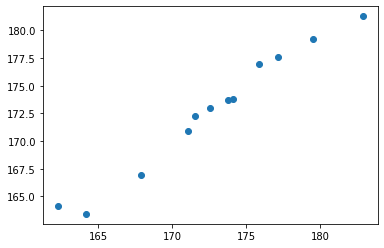

In [9]:
plt.scatter(y_test, y_pred, marker='o')

### AR Model Stuff

In [10]:
m_df = apple_df.drop(columns=['Date', 'Open', 'Close', 'Low', 'Volume'])

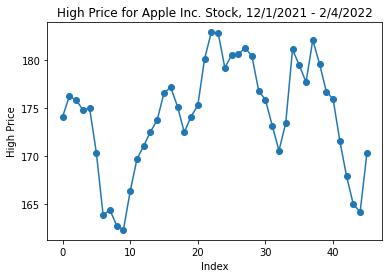

In [11]:
plt.plot(m_df['High'], marker='o')

plt.ylabel('High Price')
plt.xlabel('Index')
plt.title('High Price for Apple Inc. Stock, 12/1/2021 - 2/4/2022')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(m_df['High'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -2.600763674738335,
 'pvalue': 0.092839534101817,
 'usedlag': 1,
 'nobs': 44,
 'criticalvalues': {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 'icbest': 170.10200156732463}

The pvalue for this test indicates that we may need to take the difference of subsequent values in order to effectively locate the correct lag value(s)

In [13]:
m_df['Diff'] = m_df['High'] - m_df['High'].shift(1)

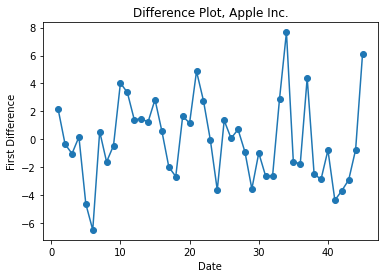

In [14]:
plt.plot(m_df['Diff'], marker='o')

plt.ylabel('First Difference')
plt.xlabel('Date')
plt.title('Difference Plot, Apple Inc.')
plt.show()

In [15]:
result = adfuller(m_df['Diff'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -4.533718438819945,
 'pvalue': 0.00017081950919894896,
 'usedlag': 0,
 'nobs': 44,
 'criticalvalues': {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 'icbest': 171.33591032902612}

By these results, we know we should use the difference to find the lag value (pvalue < 0.05)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


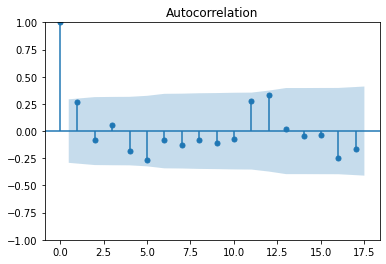

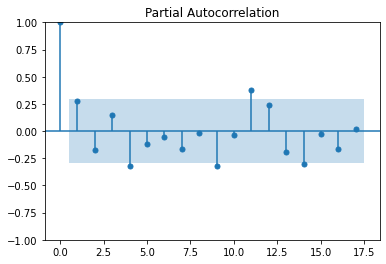

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(m_df['Diff'].dropna())
fig2=plot_pacf(m_df['Diff'].dropna())

In [17]:
# seems lag should be 1 - test various values?
from statsmodels.tsa.ar_model import AutoReg as ar
res = ar(endog = m_df['High'], lags = [1,5,10]).fit()

In [18]:
new_dates=[m_df.index[-1]+x for x in range(1, 11)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)

In [19]:
df_pred

,High,Diff
46,NaN,NaN
47,NaN,NaN
48,NaN,NaN
49,NaN,NaN
50,NaN,NaN
51,NaN,NaN
52,NaN,NaN
53,NaN,NaN
54,NaN,NaN
55,NaN,NaN


In [20]:
ar_df = pd.concat([m_df, df_pred])

In [21]:
# start at the end of original data, go til the end of this new dataframe
ar_df['predictions']=res.predict(start=m_df.shape[0],end=ar_df.shape[0])

<AxesSubplot:>

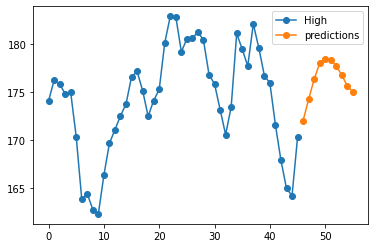

In [22]:
# High contrast plot of price versus predictions for future highs
ar_df[['High', 'predictions']].plot(marker='o')

Seems that a value of 10 actually produced some better predictions than other values

In [23]:
# export model for dashboard
from joblib import dump, load
dump(res, 'autoreg.model')

['autoreg.model']

### ARIMA Model Creation

It appears from autocorrelation and part. autocorrelation plots that the values for p and q should be 1. d should also be 1 since we took the first difference to uncover the p and q values.

In [56]:
from statsmodels.tsa.arima.model import ARIMA
arima_mdl = ARIMA(endog=m_df['High'], order=(10,1,1)).fit()

In [57]:
arima_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                   46
Model:                ARIMA(10, 1, 1)   Log Likelihood                -102.476
Date:                Thu, 10 Feb 2022   AIC                            228.952
Time:                        09:34:09   BIC                            250.632
Sample:                             0   HQIC                           237.035
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1487      0.645     -0.231      0.818      -1.412       1.115
ar.L2         -0.1978      0.287     -0.691      0.490      -0.759       0.364
ar.L3         -0.0138      0.231     -0.060      0.952      -0.467       0.439
ar.L4         -0.1855      0.234     -0.794      0.427      -0.644       0.273
ar.L5         -0.4247      0.306     -1.389      0.165      -1.024       0.174
ar.L6         -0.0999      0.285     -0.351      0.726      -0.658       0.459
ar.L7         -0.2636      0.175     -1.510      0.131      -0.606       0.079
ar.L8         -0.1424      0.239     -0.597      0.550      -0.610       0.325
ar.L9         -0.1981      0.198     -1.003      0.316      -0.585       0.189
ar.L10        -0.3566      0.171     -2.087      0.037      -0.692      -0.022
ma.L1          0.5004      0.657      0.762      0.446      -0.787       1.788
sigma2         5.1961      1.453      3.576      0.000       2.348       8.044
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.66   Prob(JB):                         0.54
Heteroskedasticity (H):               2.17   Skew:                             0.38
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

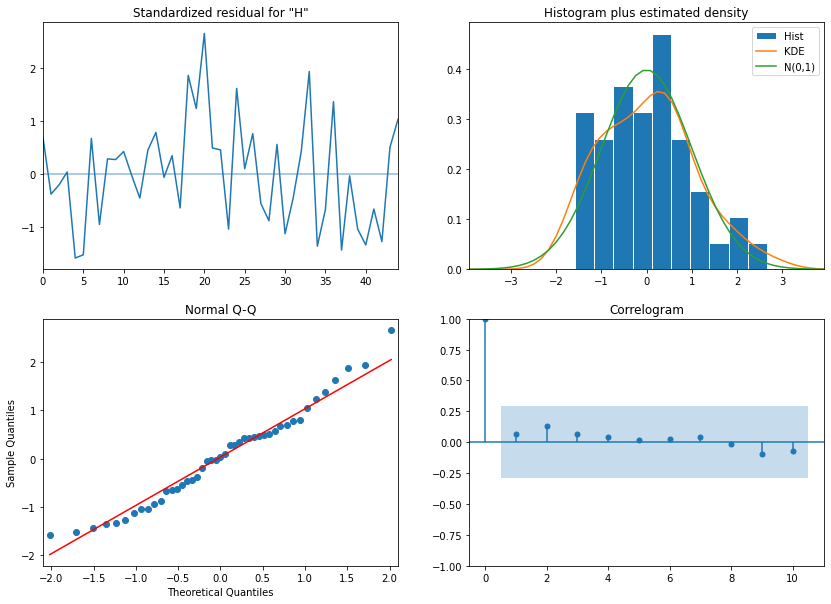

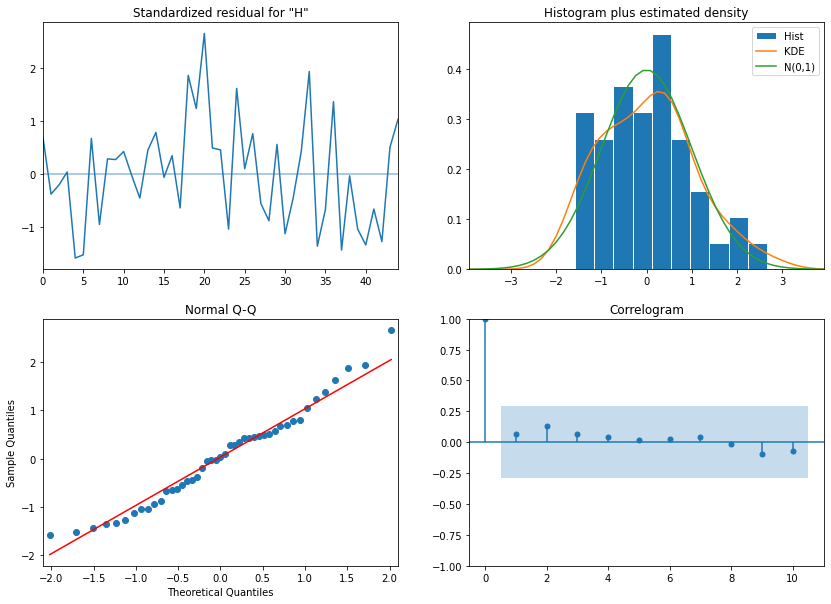

In [58]:
arima_mdl.plot_diagnostics(figsize = (14, 10))

In [74]:
new_dates=[m_df.index[-1]+x for x in range(1, 11)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)
ar_df = pd.concat([m_df, df_pred])
ar_df['predictions']=arima_mdl.predict(start=m_df.shape[0],end=ar_df.shape[0])

<AxesSubplot:>

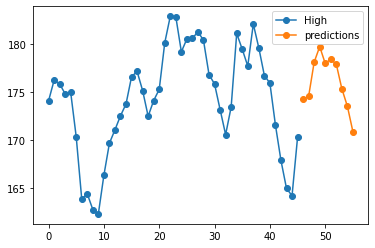

In [75]:
ar_df[['High', 'predictions']].plot(marker='o')

In [ ]:
dump(arima_mdl, 'arima.model')